In [1]:
# # Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random
import tensorflow as tf
import seaborn as sns
import random

from sklearn.utils import shuffle
from matplotlib import image
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Suppress keras warnings
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
random.seed(432)

In [2]:
def load_metadata(data_folder, train_file, validation_file, test_file, column_names):
    """Reads the .csv files containing metadata (e.g. file location, class label) about the data images.
    
    Parameters:
    data_folder (str): file path to the folder containing the csv file.
    train_file (str): file name of the file containing metadata for the training set.
    validation_file (str): file name of the file containing metadata for the validation set.
    test_file (str): file name of the file containing metadata for the test set.
    column_names (list): array containing the column names for the csv files
    
    Returns:
    the read trainig, validation, and test files.
    """
    training_df = pd.read_csv(data_folder + train_file, names = column_names, skiprows=1)
    validation_df = pd.read_csv(data_folder + validation_file, names = column_names, skiprows=1)
    test_df = pd.read_csv(data_folder + test_file, names = column_names, skiprows=1)
    
    return training_df, validation_df, test_df


In [3]:
input_folder = "/kaggle/input/"
dataset_folder = input_folder + "eurosat-dataset/" + "EuroSAT/"
column_names =  ["id", "path", "class_id", "class_name"]

training_df, validation_df, test_df = load_metadata(dataset_folder,
                                                    "train.csv",
                                                    "validation.csv",
                                                    "test.csv",
                                                    column_names)

In [4]:
# Extract labels names
labels = []
for element in (training_df["class_name"].unique()):
    labels.append(element)

# Undersampling and Oversampling approach

In [5]:
# Define the functions

def extract_unique_names(df, column=str):
    """
    Extracts the unique labels for the dataframe
    
    df: the target dataframe for which to get labels
    column: str, the column name containing lable information
    """
    labels = []
    for element in (df[column].unique()):
        labels.append(element)
    return labels

def get_min(df, target_column=str, classes=list):
    """
    Get the class with the least amount of instances in the dataset (minority class).
    
    df: the dataframe for which to find the minority class
    target_column: str, df column containing information about classes/labels
    classes: list, a list of all unique classes contained in the dataframe
    """
    min_count = len(df)
    for label in classes:
        count = df[target_column].value_counts()[label]
        if count < min_count:
            min_count = count
            min_variable = label
    return min_count, min_variable

def get_max(df, target_column=str, classes=list):
    """
    Get the class with the most instances in the dataset (majority class).
    
    df: the dataframe for which to find the majority class
    target_column: str, df column containing information about classes/labels
    classes: list, a list of all unique classes contained in the dataframe
    """
    max_count = 0
    for label in classes:
        count = df[target_column].value_counts()[label]
        if count > max_count:
            max_count = count
            max_variable = label
    return max_count, max_variable

def undersample(df, target_column=str, classes=list):
    """
    Undersample the dataset so that all labels have the same amount of instances.
    This is recommended if one has a lot of data.
    
    df: the dataframe to undersample
    target_column: str, the name of the column containing class/label information
    classes: list, a list containing all unique classes present in the dataset
    
    Returns: a dataframe containing as many instances per class as the amount of instances of the
    minority class (the class with the least instances) in the original data frame
    """
    nMax, label = get_min(df, target_column, classes)
    res = df.groupby(target_column,
                     as_index=False,
                     group_keys=False).apply(lambda x: x.sample(n=min(nMax, len(x))))
    # Now the data frame is ordered by class. That could be a problem when training the
    # CNN in batches (better if the model sees all classes with all batches). Hence, reshuffle:
    res = shuffle(res)
    return res

## Undersampling

In [6]:
# Training set

train_classes = extract_unique_names(training_df, "class_name")
val_classes   = extract_unique_names(validation_df, "class_name")
test_classes  = extract_unique_names(test_df, "class_name")

if train_classes.sort() == val_classes.sort() == test_classes.sort():
    classes = train_classes
else:
    print("!!Warning: Classes are different for the training, validation, and test sets!!")

train_min_count, train_min_variable = get_min(training_df, "class_name", classes)
val_min_count, val_min_variable = get_min(validation_df, "class_name", classes)
test_min_count, test_min_variable = get_min(test_df, "class_name", classes)

print("Min count, Min variable")
print("Train", train_min_count, train_min_variable)
print("Valid", val_min_count, val_min_variable)
print("Test ", test_min_count, test_min_variable)


Min count, Min variable
Train 1400 Pasture
Valid 400 Pasture
Test  200 Pasture


In [7]:
# Perform undersampling on all classes

train_df_under = undersample(training_df, "class_name", classes)
val_df_under = undersample(validation_df, "class_name", classes)
test_df_under = undersample(test_df, "class_name", classes)

print(f"Undersampled training dataframe length: {len(train_df_under)}")
# print(train_df_under['class_name'].value_counts())

print(f"\nUndersampled validation dataframe length: {len(val_df_under)}")
# print(val_df_under['class_name'].value_counts())

print(f"\nUndersampled test dataframe length: {len(test_df_under)}\n")
# print(test_df_under['class_name'].value_counts())


Undersampled training dataframe length: 14000

Undersampled validation dataframe length: 4000

Undersampled test dataframe length: 2000



In [8]:
test_df

,id,path,class_id,class_name
0,2438,AnnualCrop/AnnualCrop_1275.jpg,0,AnnualCrop
1,1018,Residential/Residential_504.jpg,7,Residential
2,3,Pasture/Pasture_787.jpg,5,Pasture
3,1011,Residential/Residential_1575.jpg,7,Residential
4,47,Pasture/Pasture_473.jpg,5,Pasture
...,...,...,...,...
2695,586,HerbaceousVegetation/HerbaceousVegetation_516.jpg,2,HerbaceousVegetation
2696,588,HerbaceousVegetation/HerbaceousVegetation_855.jpg,2,HerbaceousVegetation
2697,1985,SeaLake/SeaLake_2696.jpg,9,SeaLake
2698,1356,River/River_472.jpg,8,River


### Start with the CNN part

In [9]:
# The data is already normalized so that pixels values range from 0,255. We can rescale pixel value between
# [0,1] by divinding by 255.

rescaling_factor = 1. / 255
# Generate batches of tensor image data by setting up the generators.
# If you want to perform augmentation, add parameters to the training_generatorF
training_generator = ImageDataGenerator(rescale=rescaling_factor)
test_generator = ImageDataGenerator(rescale=rescaling_factor)

# Size of input data is 64x64 pixels
image_width, image_height = (64, 64)

batch_size = 128 # How big of a set of data to use for every training epoch

### Build train, val, test sets

In [10]:
print("Building training set.")
training_set = training_generator.flow_from_dataframe(
    dataframe=train_df_under,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False, #for replicability. Anyways they are already shuffled?
)

print("\nBuilding validation set.")
validation_set = test_generator.flow_from_dataframe(
    dataframe=val_df_under,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False,
)

print("\nBuilding test set")
test_set = test_generator.flow_from_dataframe(
    dataframe=test_df_under,
    x_col="path",
    y_col="class_name",
    directory=dataset_folder,
    target_size=(image_height, image_width),
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Building training set.
Found 14000 validated image filenames belonging to 10 classes.

Building validation set.
Found 4000 validated image filenames belonging to 10 classes.

Building test set
Found 2000 validated image filenames belonging to 10 classes.


### Check that the data distribution is uniform

Text(0.5, 1.0, 'Test set breakdown by class')

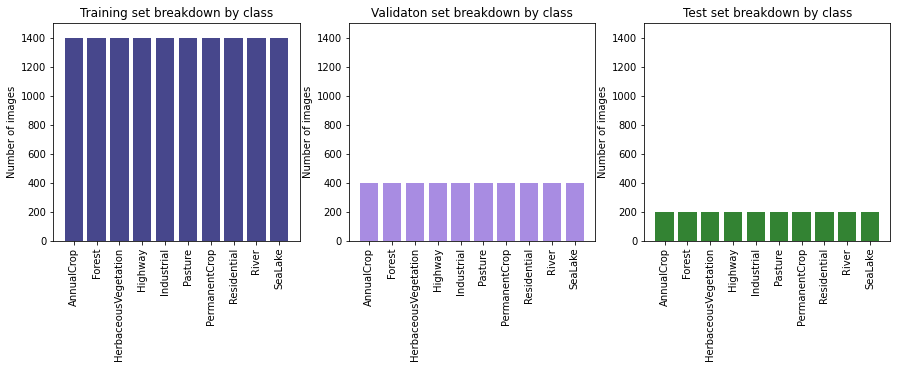

In [11]:
class_name_list = np.array(list(training_set.class_indices.keys()))
train_labels, train_count = np.unique(training_set.classes, return_counts=True)
val_labels, val_count = np.unique(validation_set.classes, return_counts=True)
test_labels, test_count = count = np.unique(test_set.classes, return_counts=True)

objects = class_name_list
y_pos = np.arange(len(objects))
n_images_train = train_count
n_images_val = val_count
n_images_test = test_count

plt.figure(figsize=(15,4))

#Plot 1
plt.subplot(1,3,1)
plt.bar(y_pos, n_images_train, align='center', alpha=0.8, color="midnightblue")
plt.xticks(y_pos, class_name_list, rotation=90)
plt.ylabel('Number of images')
plt.ylim(0,1500)
plt.title('Training set breakdown by class')

#Plot 2
plt.subplot(1,3,2)
plt.bar(y_pos, n_images_val, align='center', alpha=0.8, color="mediumpurple")
plt.xticks(y_pos, class_name_list, rotation=90)
plt.ylabel('Number of images')
plt.ylim(0,1500)
plt.title('Validaton set breakdown by class')

#Plot 3
plt.subplot(1,3,3)
plt.bar(y_pos, n_images_test, align='center', alpha=0.8, color="darkgreen")
plt.xticks(y_pos, class_name_list, rotation=90)
plt.ylabel('Number of images')
plt.ylim(0,1500)
plt.title('Test set breakdown by class')


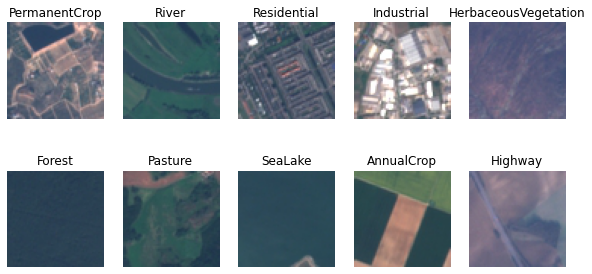

In [12]:
figure_height = 2
figure_width = 5
figure_size = (10, 5)

images, class_ids = next(training_set)
plt.figure(figsize=figure_size)
already_used_labels = []

imgs_to_plot = []
labels_to_plot = []

# Pick an image for each category from the training test:

while len(imgs_to_plot) < 9:
    for idx in range(len(images)):
        if class_name_list[class_ids[idx].astype(bool)][0] in already_used_labels:
            pass
        else:
            imgs_to_plot.append(images[idx])
            labels_to_plot.append(class_name_list[class_ids[idx].astype(bool)][0])
            already_used_labels.append(class_name_list[class_ids[idx].astype(bool)][0])

for index in range(figure_height * figure_width):
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(imgs_to_plot[index])
    plt.title(labels_to_plot[index])
    plt.axis("off")

### VGG16

In [13]:
base_vgg16 = VGG16(include_top=False, # do not include the 3 fully-connected layers at the top.
                   # Mandatory because input shape is different from original 224x224x3
                   weights='imagenet', # else None= random initialization
                   input_tensor=None,
                   input_shape=(64, 64, 3),
                   pooling=None,
                   classes=10,
                   classifier_activation='softmax')

58900480/58889256 [==============================] - 0s 0us/step


### Add custom layers

In [14]:
class_count = len(class_name_list)
model = Sequential()
model.add(base_vgg16)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(units=512, activation="relu", kernel_initializer="he_normal"))
model.add(Dense(class_count, activation="softmax"))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5130      
Total params: 15,768,906
Trainable params: 15,768,906
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_path = "/kaggle/working/eurosat_rgb_vgg16_model.h5"

# Save the weigths of the best model
checkpoint = ModelCheckpoint(filepath=model_path, monitor="val_loss", save_best_only=True)

# Reduce learning rate when val_loss stops improving for 5 epochs.
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

# Stop training if a val_loss has stopped improving for 5 epochs.
early_stopping = EarlyStopping(monitor="val_loss", patience=15, restore_best_weights=True, verbose=True)

callback_list = [checkpoint, early_stopping, reduce_lr]

In [16]:
model.compile(loss="categorical_crossentropy",
              optimizer=Adam(learning_rate=1e-4),
              metrics=['accuracy'])

In [17]:
history = model.fit(
    training_set,
    validation_data=validation_set,
    callbacks=callback_list,
    epochs=100,
    verbose=1,
)

Epoch 1/100
110/110 [==============================] - 75s 560ms/step - loss: 0.7949 - accuracy: 0.7196 - val_loss: 0.2527 - val_accuracy: 0.9150
Epoch 2/100
110/110 [==============================] - 20s 178ms/step - loss: 0.2510 - accuracy: 0.9192 - val_loss: 0.3062 - val_accuracy: 0.8963
Epoch 3/100
110/110 [==============================] - 19s 174ms/step - loss: 0.1745 - accuracy: 0.9433 - val_loss: 0.1872 - val_accuracy: 0.9360
Epoch 4/100
110/110 [==============================] - 19s 176ms/step - loss: 0.1234 - accuracy: 0.9575 - val_loss: 0.2855 - val_accuracy: 0.9137
Epoch 5/100
110/110 [==============================] - 19s 175ms/step - loss: 0.1043 - accuracy: 0.9674 - val_loss: 0.1267 - val_accuracy: 0.9632
Epoch 6/100
110/110 [==============================] - 19s 174ms/step - loss: 0.0834 - accuracy: 0.9722 - val_loss: 0.1260 - val_accuracy: 0.9622
Epoch 7/100
110/110 [==============================] - 20s 177ms/step - loss: 0.0673 - accuracy: 0.9767 - val_loss: 0.1740 -

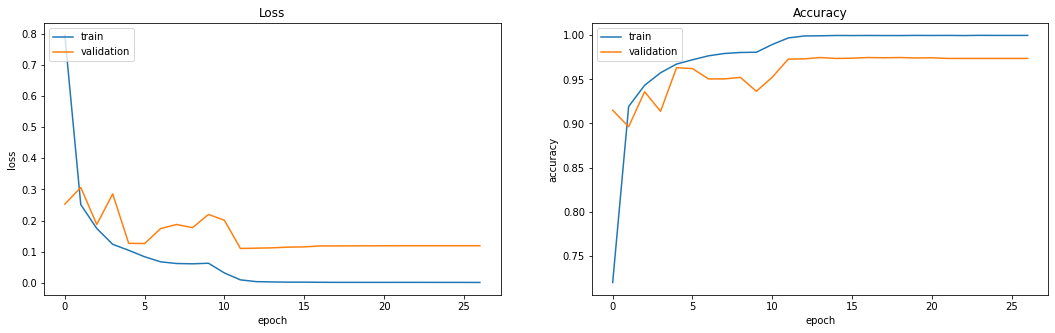

<Figure size 432x288 with 0 Axes>

In [18]:
plt.figure(figsize=(18, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")

plt.show()
plt.savefig("/kaggle/working/exp2_loss_accuracy.png")

### Evaluate the model

In [19]:
loss, accuracy = model.evaluate(test_set, verbose=1)

16/16 [==============================] - 8s 549ms/step - loss: 0.0810 - accuracy: 0.9780


In [20]:
test_set.reset()
predicted_probabilities = model.predict(test_set, steps=test_set.n, verbose=1)
# Computation is done in batches.
predicted_class_ids = np.argmax(predicted_probabilities, axis=1)

2000/2000 [==============================] - 2s 1ms/step


In [21]:
cf_matrix = confusion_matrix(test_set.labels, predicted_class_ids)
print(cf_matrix)

[[198   0   0   0   0   0   2   0   0   0]
 [  0 197   0   0   0   1   0   0   2   0]
 [  0   1 188   1   0   4   6   0   0   0]
 [  1   0   0 195   0   1   1   0   2   0]
 [  0   0   0   1 197   0   1   1   0   0]
 [  1   0   0   0   0 195   3   0   1   0]
 [  3   0   5   0   0   0 192   0   0   0]
 [  0   0   0   0   1   0   0 199   0   0]
 [  1   0   0   3   0   0   0   0 196   0]
 [  0   0   0   0   0   1   0   0   0 199]]


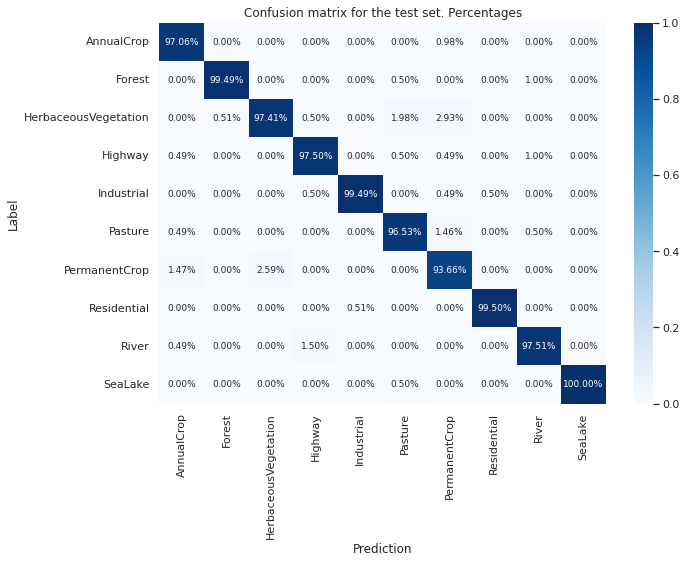

<Figure size 432x288 with 0 Axes>

In [22]:
confusion_matrix_array = confusion_matrix(y_true=test_set.labels, y_pred=predicted_class_ids)
confusion_matrix_df = pd.DataFrame(
    data=confusion_matrix_array, 
    index=class_name_list, 
    columns=class_name_list
)

plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df/np.sum(confusion_matrix_df), annot=True,
           cmap="Blues", annot_kws={"size": 9}, fmt='.2%')
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.title("Confusion matrix for the test set. Percentages")
plt.show()
plt.savefig("/kaggle/working/vgg16_exp2_confusion_percentages.png")

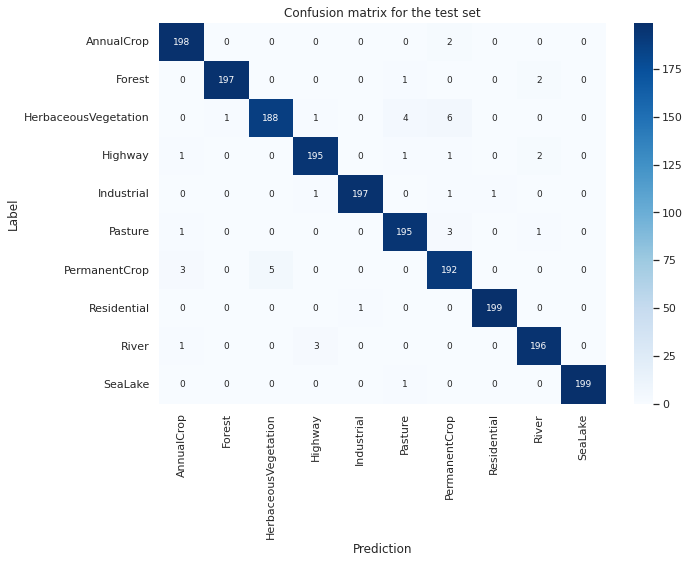

<Figure size 432x288 with 0 Axes>

In [23]:
plt.figure(figsize=(10, 7))
sns.set(font_scale=1)
sns.heatmap(confusion_matrix_df, annot=True, cmap="Blues", annot_kws={"size": 9}, fmt="g")
plt.ylabel("Label")
plt.xlabel("Prediction")
plt.title("Confusion matrix for the test set")
plt.show()
plt.savefig("/kaggle/working/vgg16_exp2_confusion.png")

### Plot wrong predictions

44 wrong predictions out of 2000


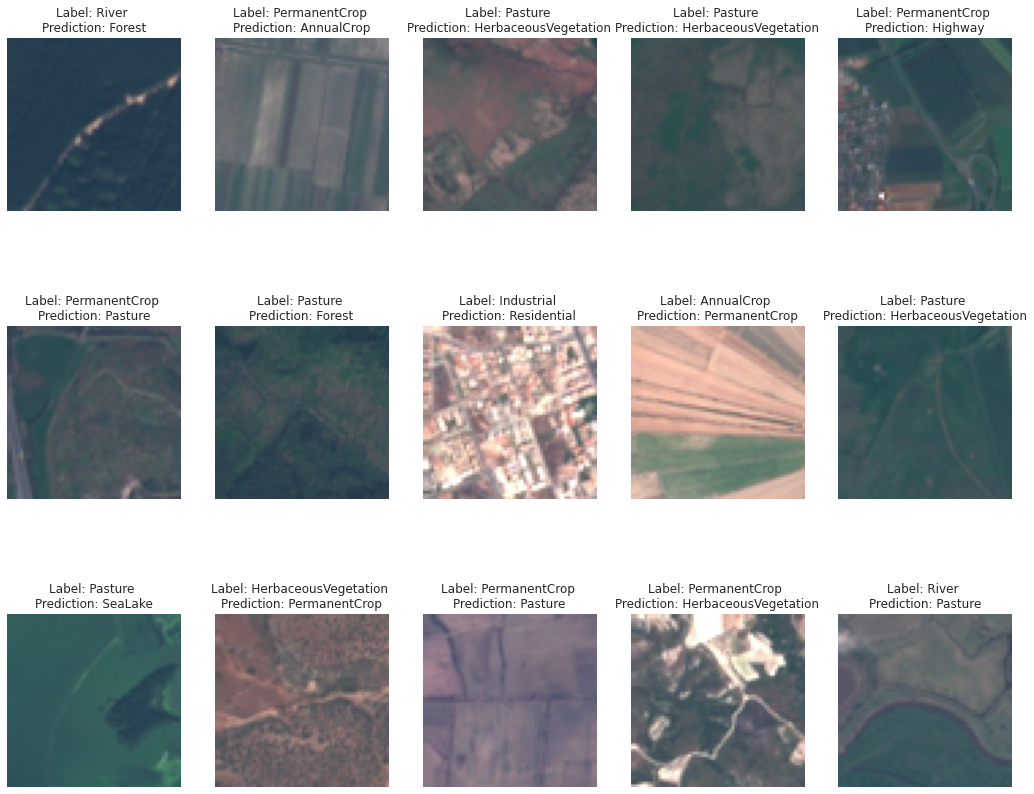

In [24]:
results_df = pd.DataFrame(
    {"label": test_set.labels, 
     "prediction": predicted_class_ids, 
     "path": test_set.filepaths
    })


mistakes = results_df["label"] != results_df["prediction"]
mistakes_df = results_df[mistakes]

print(f"{len(mistakes_df)} wrong predictions out of {len(results_df)}")


mistaken_predictions = (class_name_list[pred] for pred in mistakes_df["prediction"])
mistaken_labels = (class_name_list[label] for label in mistakes_df["label"])
mistaken_images = (image.imread(path) for path in mistakes_df["path"])

figure_height = 3
figure_width = 5

figure_size = (18, 15)
plt.figure(figsize=figure_size)
for index in range(figure_height * figure_width):
    
    label = next(mistaken_predictions)
    prediction = next(mistaken_labels)
    picture = next(mistaken_images)
    
    plt.subplot(figure_height, figure_width, index + 1)
    plt.imshow(picture)
    plt.title(f"Label: {label} \nPrediction: {prediction}")
    plt.axis("off")

#plt.savefig("/kaggle/working/vgg16_exp2_mislabeled_results.png")

